# Segmenting and Clustering Neighborhoods in Toronto

The idea of this notebook is taking from Manhanta's notebook used in Coursera. 

## 1. Importing libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
from pandas.io.json import json_normalize # library to handle JSON files
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium 
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



## 2. Download Data

In [2]:
url='https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto'
source = requests.get(url).text

In [3]:
soup = BeautifulSoup(source, 'xml')
table = soup.find('table',{'class':'wikitable sortable'})

## 3. Create DataFrame

In [4]:
# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
CDN_number = []
Neighborhood_list = []
Borough_list = []

for row in table.find_all('tr'):
    i = 0
    for r in row.find_all('td'):
        if i == 0:
            CDN_number.append(r.text.strip())
        elif i == 1:
            Neighborhood_list.append(r.text.strip())
        elif i == 2:
            Borough_list.append(r.text.strip())
        i +=1


In [5]:
df = pd.DataFrame({'CDN_number':CDN_number, 'Borough':Borough_list, 'Neighborhood':Neighborhood_list})
print('shape',df.shape)
df.head()

shape (140, 3)


,CDN_number,Borough,Neighborhood
0,129,Scarborough,Agincourt North
1,128,Scarborough,Agincourt South-Malvern West
2,20,Etobicoke,Alderwood
3,95,Old City of Toronto,Annex
4,42,North York,Banbury-Don Mills


In [6]:
path = '/Users/Naiara/Desktop/projects/Coursera_Capstone/Capstone/'
df_coordinates = pd.read_csv(path + "Neighbourhoods_Toronto.csv")

In [7]:
df_coordinates = df_coordinates.drop(columns={'_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE',
       'AREA_LONG_CODE','X', 'Y','OBJECTID', 'Shape__Area', 'Shape__Length', 'geometry','AREA_DESC'})

In [8]:
df_coordinates['AREA_NAME'] = df_coordinates['AREA_NAME'].str.replace(r'\(\d+\)','')

In [9]:
df_coordinates = df_coordinates.rename(columns={"AREA_NAME": "Neighborhood"})
df_coordinates['Neighborhood'] = df_coordinates.Neighborhood.str.strip()


In [10]:
#there are some places are not writing at the same way
l1=['Cabbagetown-South St. James Town',
 'Crescent Town',
 'Danforth - East York',
 'Mimico',
 'North St. James Town',
 'Parkdale',
 'St. Andrew-Windfields',
 'Wexford-Maryvale',
 'Yonge and Eglinton']
l2 = ['Cabbagetown-South St.James Town',
      'Taylor-Massey',
      'Danforth East York',
      'Mimico (includes Humber Bay Shores)',
      'North St.James Town',
      'South Parkdale',
      'St.Andrew-Windfields',
      'Wexford/Maryvale',
      'Yonge-Eglinton']
df['Neighborhood'] = df['Neighborhood'].replace(l1,l2)

In [11]:
df = pd.merge(df_coordinates,df, on=['Neighborhood'])

In [12]:
# Number of rows has our dataframe
df.shape

(140, 5)

In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 6 boroughs and 140 neighborhoods.


### Create a map

In [14]:
# create map of Toronto using latitude and longitude values
latitude = 43.7001114 #they are latitude and longitude of Toronto
longitude = -79.4162979
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['LATITUDE'], df['LONGITUDE'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 4.  Explore Neighborhoods
### Define Foursquare Credentials and Version

In [15]:
# @hidden_cell
CLIENT_ID  = '114NZNSDLZPAK0OJ55IWBXFFJBSGCNZBQBUYDQ4RBNSHSHWN'
CLIENT_SECRET = 'IQXB50UD15YPSB5YV0Q3HRCL0UFMBW2CIG1LPZATQ4INQRTA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


#### Now, let's get the top 100 venues that are in all neighborhood from Toronto within a radius of 500 meters.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
df = df.rename(columns={'LATITUDE':'Latitude', 'LONGITUDE': 'Longitude'})

In [24]:
LIMIT = 100
radius = 500
Toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Wychwood
Yonge-Eglinton
Yonge-St.Clair
York University Heights
Yorkdale-Glen Park
Lambton Baby Point
Lansing-Westgate
Lawrence Park North
Lawrence Park South
Leaside-Bennington
Little Portugal
Long Branch
Malvern
Maple Leaf
Markland Wood
Milliken
Mimico (includes Humber Bay Shores)
Morningside
Moss Park
Mount Dennis
Mount Olive-Silverstone-Jamestown
Mount Pleasant East
Mount Pleasant West
New Toronto
Newtonbrook East
Newtonbrook West
Niagara
North Riverdale
North St.James Town
O'Connor-Parkview
Oakridge
Oakwood Village
Old East York
Palmerston-Little Italy
Parkwoods-Donalda
Pelmo Park-Humberlea
Playter Estates-Danforth
Pleasant View
Princess-Rosethorn
Regent Park
Rexdale-Kipling
Rockcliffe-Smythe
Roncesvalles
Rosedale-Moore Park
Rouge
Runnymede-Bloor West Village
Rustic
Scarborough Village
South Parkdale
South Riverdale
St.Andrew-Windfields
Steeles
Stonegate-Queensway
Tam O'Shanter-Sullivan
Taylor-Massey
The Beaches
Thistletown-Beaumond Heights
Thorncliffe Park
Trinity-Bellwoods
Univer

In [25]:
Toronto_venues = pd.merge(Toronto_venues, df, on=['Neighborhood'])
Toronto_venues = Toronto_venues.drop(['Neighborhood Latitude','Neighborhood Longitude'], axis=1)
Toronto_venues = Toronto_venues.dropna()

## 5. EDA

Now, we have the dataframe which contains all information about the Borough, Neighbourhoods and Venues from New York, therefore, we are going to analyse this data.

In [26]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2030, 9)


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Longitude,Latitude,CDN_number,Borough
0,Wychwood,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market,-79.425515,43.676919,94,Old City of Toronto
1,Wychwood,Wychwood Barns,43.680028,-79.423810,Event Space,-79.425515,43.676919,94,Old City of Toronto
2,Wychwood,Hillcrest Park,43.676012,-79.424787,Park,-79.425515,43.676919,94,Old City of Toronto
3,Wychwood,Annabelle Pasta Bar,43.675445,-79.423341,Italian Restaurant,-79.425515,43.676919,94,Old City of Toronto
4,Yonge-Eglinton,North Toronto Memorial Community Centre,43.706098,-79.404337,Gym,-79.403590,43.704689,100,Old City of Toronto


#### Firstly, we are going to see how many Neightbourhoods are for each Borough.

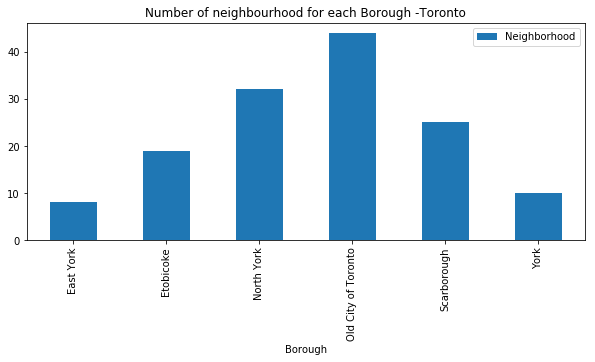

In [27]:
fig, axs = plt.subplots(1,figsize=(10,4))
Toronto_venues.groupby(['Borough'])['Neighborhood'].nunique().to_frame().plot.bar(ax = axs)
plt.title('Number of neighbourhood for each Borough -Toronto')
plt.show()
fig.savefig('/Users/Naiara/Desktop/projects/Coursera_Capstone/Capstone/Figures/Toronto_Borough.png')

Let's check what type of Venues is in Dataframe

In [28]:
text = sorted(list(Toronto_venues['Venue Category'].values))

In [29]:
text = ['_'.join(i.split()) for i in text]

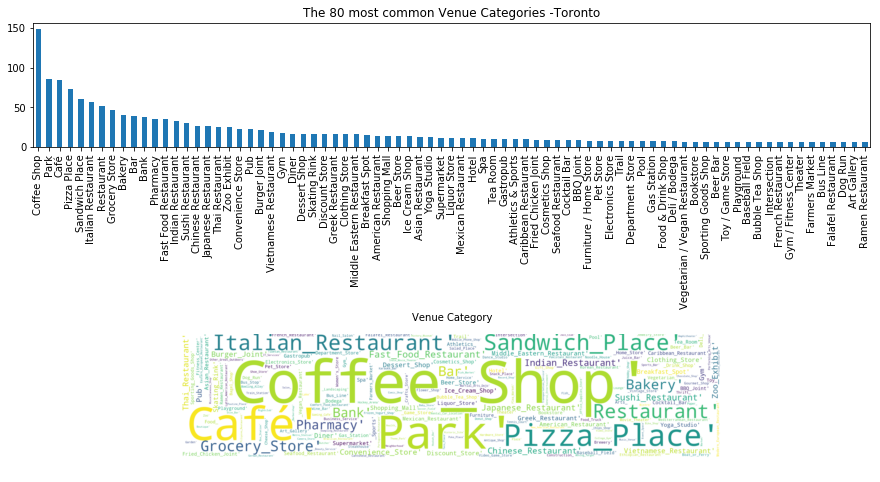

In [30]:
fig, axs = plt.subplots(2,1,figsize=(15,8))
plt.subplots_adjust(hspace=1.5)
aux_df = Toronto_venues.groupby(['Venue Category'])['Venue Category'].count().sort_values(ascending=False)
aux_df[0:79].plot.bar(ax=axs[0])
axs[0].set_title('The 80 most common Venue Categories -Toronto')

stopwords = set(STOPWORDS)
wc = WordCloud(background_color="white",width=2600, height=600, collocations=False,stopwords = stopwords)
wc.generate(str(text))
axs[1].imshow(wc, interpolation='bilinear')

axs[1].axis("off")

plt.show()

fig.savefig('/Users/Naiara/Desktop/projects/Coursera_Capstone/Capstone/Figures/Toronto_venues.png')



Let's check how many venues were returned for each neighborhood and borough

In [31]:
Toronto_venues.groupby(['Borough','Neighborhood'])['Venue'].count().to_frame()

Venue
Borough   Neighborhood             
East York Broadview North         4
          Danforth East York      6
          Leaside-Bennington     18
          O'Connor-Parkview      13
          Old East York           4
...                             ...
York      Lambton Baby Point      3
          Mount Dennis            4
          Oakwood Village        10
          Rockcliffe-Smythe      10
          Weston                 15

[138 rows x 1 columns]

#### Let's find out how many unique categories can be curated from all the returned venues


In [32]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 287 uniques categories.


### 5.1. Analyze each Neighborhood

In [33]:
# one hot encoding
toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
a = ['Neighborhood']
aux = list(toronto_onehot.columns)
aux.remove('Neighborhood')
fixed_columns = a + aux

#fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Wychwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wychwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wychwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wychwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Yonge-Eglinton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#shape
toronto_onehot.shape

(2030, 287)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [35]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt North,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.055556,0.0,0.0,0.0,0.055556,0.000000,0.000000,0.0,0.0
1,Agincourt South-Malvern West,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,Alderwood,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,Annex,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,Banbury-Don Mills,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.041667,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,Wychwood,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
134,Yonge-Eglinton,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
135,Yonge-St.Clair,0.0,0.018519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.018519,0.0,0.0,0.0,0.000000,0.000000,0.018519,0.0,0.0
136,York University Heights,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


#### Let's print each neighborhood along with the top 5 most common venues

In [36]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North----
                  venue  freq
0    Chinese Restaurant  0.11
1        Sandwich Place  0.06
2              Pharmacy  0.06
3  Fast Food Restaurant  0.06
4        Clothing Store  0.06


----Agincourt South-Malvern West----
                venue  freq
0  Chinese Restaurant  0.29
1       Shopping Mall  0.10
2                Café  0.05
3          Restaurant  0.05
4        Noodle House  0.05


----Alderwood----
                venue  freq
0         Pizza Place  0.33
1  Athletics & Sports  0.17
2   Convenience Store  0.17
3         Coffee Shop  0.17
4            Pharmacy  0.17


----Annex----
            venue  freq
0  Sandwich Place  0.11
1             Pub  0.07
2            Café  0.07
3            Park  0.07
4     Coffee Shop  0.07


----Banbury-Don Mills----
            venue  freq
0    Gourmet Shop  0.08
1  Clothing Store  0.08
2     Coffee Shop  0.08
3     Pizza Place  0.08
4  Cosmetics Shop  0.08


----Bathurst Manor----
                venue  freq
0   Convenience 

                       venue  freq
0                Pizza Place  0.11
1                 Bagel Shop  0.11
2  Middle Eastern Restaurant  0.06
3          Korean Restaurant  0.06
4                        Spa  0.06


----Forest Hill South----
                     venue  freq
0                     Park   0.5
1               Playground   0.5
2       African Restaurant   0.0
3               Nail Salon   0.0
4  North Indian Restaurant   0.0


----Glenfield-Jane Heights----
           venue  freq
0           Park   0.4
1           Pool   0.2
2  Moving Target   0.2
3       Tea Room   0.2
4     Nail Salon   0.0


----Greenwood-Coxwell----
               venue  freq
0  Indian Restaurant  0.23
1               Café  0.10
2      Grocery Store  0.08
3            Brewery  0.05
4             Bistro  0.03


----Guildwood----
            venue  freq
0           Hotel   0.2
1            Park   0.2
2  Sandwich Place   0.2
3     Pizza Place   0.2
4     Coffee Shop   0.2


----Henry Farm----
                 v

                venue  freq
0       Grocery Store  0.25
1  Seafood Restaurant  0.25
2         Pastry Shop  0.25
3                 Bar  0.25
4           Nightclub  0.00


----Palmerston-Little Italy----
                           venue  freq
0                 Sandwich Place  0.10
1                   Dessert Shop  0.10
2                           Café  0.10
3  Vegetarian / Vegan Restaurant  0.05
4              Martial Arts Dojo  0.05


----Parkwoods-Donalda----
                     venue  freq
0        Food & Drink Shop   0.5
1                     Park   0.5
2          Organic Grocery   0.0
3                   Office   0.0
4  North Indian Restaurant   0.0


----Pelmo Park-Humberlea----
                    venue  freq
0        Video Game Store  0.25
1                  Bakery  0.25
2  Furniture / Home Store  0.25
3               Locksmith  0.25
4      African Restaurant  0.00


----Playter Estates-Danforth----
              venue  freq
0  Greek Restaurant  0.14
1               Pub  0.08
2 

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [37]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 15 #taking 10 venues on the top

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Agincourt North,Chinese Restaurant,Pizza Place,Park,Fast Food Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Sandwich Place,Beer Store,Bakery,Clothing Store,Japanese Restaurant,Discount Store,Bank,Vietnamese Restaurant,Convenience Store
1,Agincourt South-Malvern West,Chinese Restaurant,Shopping Mall,Mediterranean Restaurant,BBQ Joint,Pool Hall,Restaurant,Noodle House,Cantonese Restaurant,Seafood Restaurant,Café,Motorcycle Shop,Filipino Restaurant,Malay Restaurant,Bank,Pizza Place
2,Alderwood,Pizza Place,Convenience Store,Pharmacy,Athletics & Sports,Coffee Shop,Falafel Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Farm,Eastern European Restaurant,Farmers Market,Fast Food Restaurant
3,Annex,Sandwich Place,Café,Park,Coffee Shop,Pub,Pet Store,BBQ Joint,Metro Station,Burger Joint,Pharmacy,Middle Eastern Restaurant,Liquor Store,French Restaurant,Cheese Shop,Donut Shop
4,Banbury-Don Mills,Pizza Place,Coffee Shop,Clothing Store,Gourmet Shop,Cosmetics Shop,Sporting Goods Shop,Shopping Mall,Furniture / Home Store,Liquor Store,Spa,Movie Theater,Shoe Store,Italian Restaurant,Sandwich Place,Cantonese Restaurant


## 6. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood.

In [49]:
def cluster_variance(n):
    toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2).fit(toronto_grouped_clustering)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n


In [50]:
variances,K,n=cluster_variance(10)

Initialization complete
Iteration  0, inertia 61.308
Iteration  1, inertia 28.404
Converged at iteration 1: center shift 0.000000e+00 within tolerance 7.196676e-08
Initialization complete
Iteration  0, inertia 61.308
Iteration  1, inertia 28.404
Converged at iteration 1: center shift 0.000000e+00 within tolerance 7.196676e-08
Initialization complete
Iteration  0, inertia 63.444
Iteration  1, inertia 28.404
Converged at iteration 1: center shift 0.000000e+00 within tolerance 7.196676e-08
Initialization complete
Iteration  0, inertia 51.469
Iteration  1, inertia 28.404
Converged at iteration 1: center shift 0.000000e+00 within tolerance 7.196676e-08
Initialization complete
Iteration  0, inertia 64.806
Iteration  1, inertia 28.404
Converged at iteration 1: center shift 0.000000e+00 within tolerance 7.196676e-08
Initialization complete
Iteration  0, inertia 62.140
Iteration  1, inertia 28.404
Converged at iteration 1: center shift 0.000000e+00 within tolerance 7.196676e-08
Initialization c

Iteration 0, inertia 25.08051697099403
start iteration
done sorting
end inner loop
Iteration 1, inertia 24.72479369290326
start iteration
done sorting
end inner loop
Iteration 2, inertia 24.680043563188555
start iteration
done sorting
end inner loop
Iteration 3, inertia 24.64712530662996
start iteration
done sorting
end inner loop
Iteration 4, inertia 24.633756299888102
start iteration
done sorting
end inner loop
Iteration 5, inertia 24.633756299888102
center shift 0.000000e+00 within tolerance 7.196677e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 27.435040914175048
start iteration
done sorting
end inner loop
Iteration 1, inertia 26.62652149454661
start iteration
done sorting
end inner loop
Iteration 2, inertia 24.70972981902757
start iteration
done sorting
end inner loop
Iteration 3, inertia 24.46731097452492
start iteration
done sorting
end inner loop
Iteration 4, inertia 24.437473309057218
start iteration
done sorting
end inner loop
It

Iteration 4, inertia 22.316897793295706
start iteration
done sorting
end inner loop
Iteration 5, inertia 22.316897793295706
center shift 0.000000e+00 within tolerance 7.196677e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 23.56765801400486
start iteration
done sorting
end inner loop
Iteration 1, inertia 22.713790292662907
start iteration
done sorting
end inner loop
Iteration 2, inertia 22.668241908224743
start iteration
done sorting
end inner loop
Iteration 3, inertia 22.63029698766244
start iteration
done sorting
end inner loop
Iteration 4, inertia 22.59735920959731
start iteration
done sorting
end inner loop
Iteration 5, inertia 22.59735920959731
center shift 0.000000e+00 within tolerance 7.196677e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 23.69254808068473
start iteration
done sorting
end inner loop
Iteration 1, inertia 23.00681657530876
start iteration
done sorting
end inner loop
Iterat

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 23.087448112856634
start iteration
done sorting
end inner loop
Iteration 1, inertia 22.909497245703044
start iteration
done sorting
end inner loop
Iteration 2, inertia 22.89307220111424
start iteration
done sorting
end inner loop
Iteration 3, inertia 22.865830063881898
start iteration
done sorting
end inner loop
Iteration 4, inertia 22.68514921149176
start iteration
done sorting
end inner loop
Iteration 5, inertia 22.63042845009991
start iteration
done sorting
end inner loop
Iteration 6, inertia 22.63042845009991
center shift 0.000000e+00 within tolerance 7.196677e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 21.58563196961296
start iteration
done sorting
end inner loop
Iteration 1, inertia 21.37034664702771
start iteration
done sorting
end inner loop
Iteration 2, inertia 21.238332324621005
start iteration
done sorting
end inner loop
Iteration 3, inert

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 20.152678696891506
start iteration
done sorting
end inner loop
Iteration 1, inertia 19.93479418228902
start iteration
done sorting
end inner loop
Iteration 2, inertia 19.890665334061953
start iteration
done sorting
end inner loop
Iteration 3, inertia 19.86118583539625
start iteration
done sorting
end inner loop
Iteration 4, inertia 19.855003834079515
start iteration
done sorting
end inner loop
Iteration 5, inertia 19.855003834079515
center shift 0.000000e+00 within tolerance 7.196677e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 21.067375683439383
start iteration
done sorting
end inner loop
Iteration 1, inertia 20.556714018843465
start iteration
done sorting
end inner loop
Iteration 2, inertia 20.5284251974211
start iteration
done sorting
end inner loop
Iteration 3, inertia 20.519101162506008
start iteration
done sorting
end inner loop
Iteration 4, ine

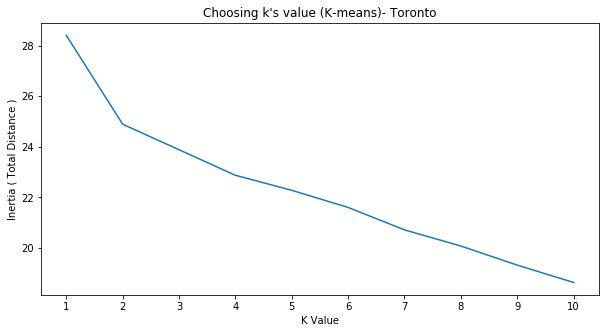

In [51]:
fig, axs =  plt.subplots(1,1, figsize=(10,5))
axs.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.title("Choosing k's value (K-means)- Toronto")
plt.show()
fig.savefig('/Users/Naiara/Desktop/projects/Coursera_Capstone/Capstone/Figures/Toronto_K-means.png')

In [52]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 3, 1, 1, 3, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [53]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df.drop('CDN_number', axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged = toronto_merged.dropna()
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

toronto_merged.head() # check the last columns!

,Neighborhood,Longitude,Latitude,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Wychwood,-79.425515,43.676919,Old City of Toronto,3,Park,Italian Restaurant,Farmers Market,Event Space,Zoo Exhibit,Exhibit,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Falafel Restaurant,Dumpling Restaurant,Farm,Fast Food Restaurant,Field
1,Yonge-Eglinton,-79.403590,43.704689,Old City of Toronto,1,Coffee Shop,Restaurant,Fast Food Restaurant,Gym,Japanese Restaurant,Salad Place,Breakfast Spot,Liquor Store,Buffet,Skating Rink,Shopping Mall,Caribbean Restaurant,Sandwich Place,Burger Joint,Movie Theater
2,Yonge-St.Clair,-79.397871,43.687859,Old City of Toronto,1,Coffee Shop,Italian Restaurant,Sushi Restaurant,Restaurant,Grocery Store,Bank,Bagel Shop,Pizza Place,Pub,Thai Restaurant,Café,Gym,Sandwich Place,Chiropractor,Modern European Restaurant
3,York University Heights,-79.488883,43.765736,North York,1,Massage Studio,Coffee Shop,Miscellaneous Shop,Sushi Restaurant,Fast Food Restaurant,Caribbean Restaurant,Bar,Japanese Restaurant,Bank,Pizza Place,Dim Sum Restaurant,Diner,Fish & Chips Shop,Filipino Restaurant,Cupcake Shop
4,Yorkdale-Glen Park,-79.457108,43.714672,North York,1,Restaurant,Fast Food Restaurant,Athletics & Sports,Greek Restaurant,Bookstore,Sandwich Place,Rental Car Location,Bar,Bank,Coffee Shop,Bowling Alley,Italian Restaurant,Fried Chicken Joint,Furniture / Home Store,Grocery Store


In [56]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 7. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

In [57]:
def plotting_cluster(cluster):
    # get all venues from cluster dataframe and convert to list
    venues = [item for sublist in cluster.iloc[:,1:].values.tolist() for item in sublist]
    #create dictionary with key: category venue and value: frequency of the category venues.
    venues_dict = {i:venues.count(i) for i in set(venues)}
    #sorted by value descdending the dict
    venues_dict = {r: venues_dict[r] for r in sorted(venues_dict, key=venues_dict.get, reverse=True)}
    venues_30 = {key:value for key,value in list(venues_dict.items())[0:30]}
    #create a dataframe with name category and frequency
    column_names = ['Venues_30', 'freq'] 
    df = pd.DataFrame(columns=column_names)
    df['venues_30'] = list(venues_30.keys())
    df['freq'] = list(venues_30.values()) 
    
    #Plots
    fig, axs = plt.subplots(2,1,figsize=(10,15))
    plt.subplots_adjust(hspace=-0.3)
    #plot bar
    sns.barplot(x='freq', y="venues_30", data=df, ax = axs[1])
    axs[1].set(title='the 30 most number of venues')
    #plot wordcloud
    wc = WordCloud(background_color="white",width=2600, height=600)
    wc.generate(str(venues))
    axs[0].imshow(wc, interpolation='bilinear')
    axs[0].axis("off")
    axs[0].set(title='venues from cluster')
    plt.show()

#### Cluster 1

In [58]:
cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_1

,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
38,-79.544559,Playground,Zoo Exhibit,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Farm,Dumpling Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
135,-79.260382,Playground,Discount Store,Coffee Shop,Zoo Exhibit,Falafel Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Farm,Eastern European Restaurant,Farmers Market,Fast Food Restaurant,Field


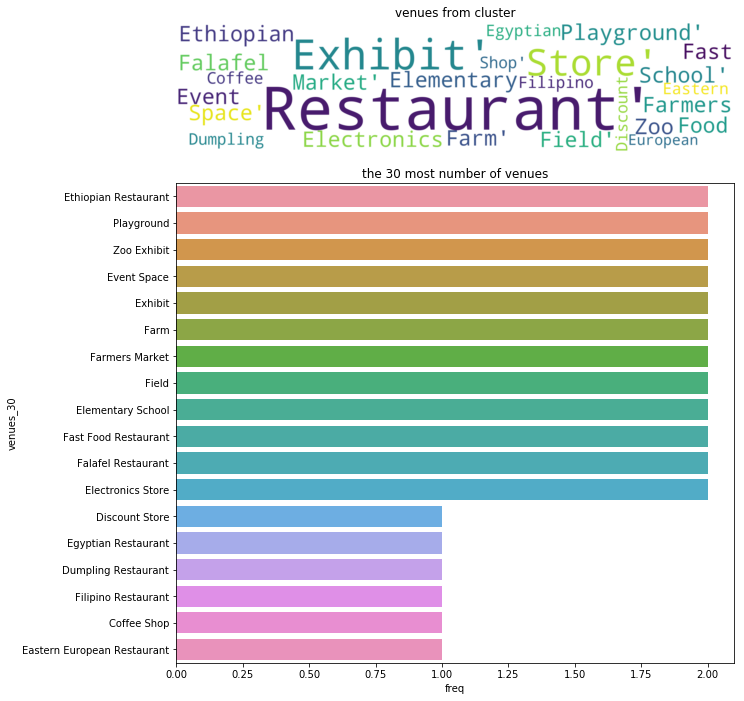

In [59]:
plotting_cluster(cluster_1)

#### Cluster 2

In [60]:
cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_2

,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,-79.403590,Coffee Shop,Restaurant,Fast Food Restaurant,Gym,Japanese Restaurant,Salad Place,Breakfast Spot,Liquor Store,Buffet,Skating Rink,Shopping Mall,Caribbean Restaurant,Sandwich Place,Burger Joint,Movie Theater
2,-79.397871,Coffee Shop,Italian Restaurant,Sushi Restaurant,Restaurant,Grocery Store,Bank,Bagel Shop,Pizza Place,Pub,Thai Restaurant,Café,Gym,Sandwich Place,Chiropractor,Modern European Restaurant
3,-79.488883,Massage Studio,Coffee Shop,Miscellaneous Shop,Sushi Restaurant,Fast Food Restaurant,Caribbean Restaurant,Bar,Japanese Restaurant,Bank,Pizza Place,Dim Sum Restaurant,Diner,Fish & Chips Shop,Filipino Restaurant,Cupcake Shop
4,-79.457108,Restaurant,Fast Food Restaurant,Athletics & Sports,Greek Restaurant,Bookstore,Sandwich Place,Rental Car Location,Bar,Bank,Coffee Shop,Bowling Alley,Italian Restaurant,Fried Chicken Joint,Furniture / Home Store,Grocery Store
7,-79.403978,Sushi Restaurant,Italian Restaurant,Bakery,Asian Restaurant,Sandwich Place,Bank,Pub,Coffee Shop,Cosmetics Shop,Burger Joint,Clothing Store,Seafood Restaurant,Japanese Restaurant,Shoe Store,Shopping Mall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,-79.471440,Coffee Shop,Hardware Store,Thai Restaurant,Bar,Furniture / Home Store,Café,Electronics Store,Grocery Store,Italian Restaurant,Nail Salon,Cosmetics Shop,Diner,Speakeasy,Sushi Restaurant,Supermarket
134,-79.471437,Pizza Place,Bakery,Fast Food Restaurant,Latin American Restaurant,Thrift / Vintage Store,Sandwich Place,Wine Shop,Field,Farmers Market,Farm,Filipino Restaurant,Exhibit,Event Space,Ethiopian Restaurant,Elementary School
136,-79.397240,Café,Mexican Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Grocery Store,Coffee Shop,Gaming Cafe,Bakery,Cheese Shop,Restaurant,Record Shop,Bar,Caribbean Restaurant,Cocktail Bar,Fish Market
137,-79.547863,Coffee Shop,Pizza Place,Grocery Store,Bus Line,Zoo Exhibit,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Farm,Falafel Restaurant,Eastern European Restaurant,Farmers Market,Fast Food Restaurant


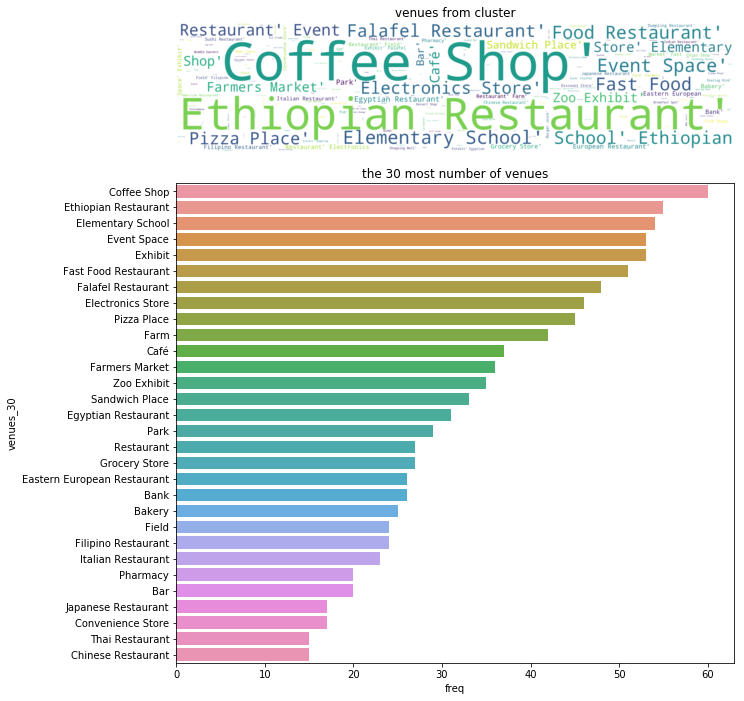

In [61]:
plotting_cluster(cluster_2)

#### Cluster 3

In [62]:
cluster_3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_3

,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
25,-79.431422,Photography Studio,Zoo Exhibit,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Farm,Dumpling Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


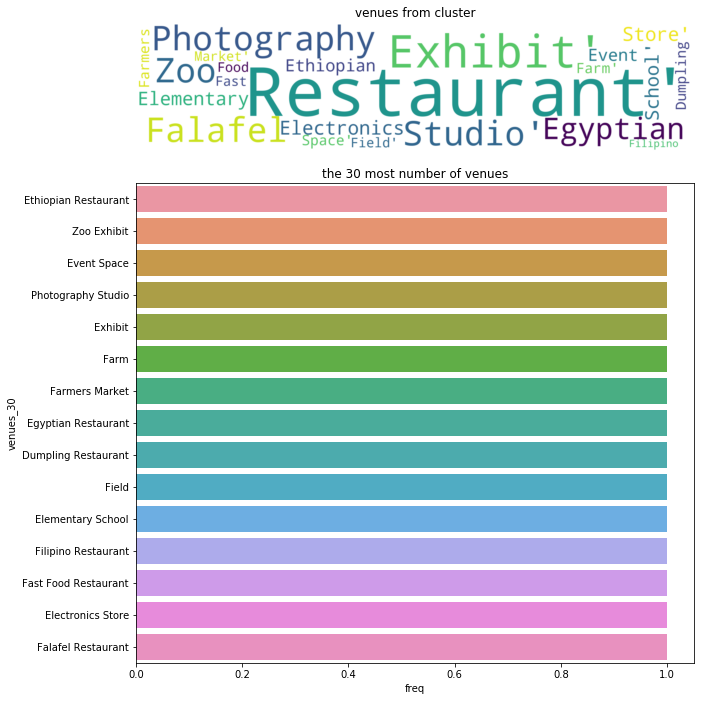

In [63]:
plotting_cluster(cluster_3)

#### Cluster 4

In [64]:
cluster_4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster_4

,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,-79.425515,Park,Italian Restaurant,Farmers Market,Event Space,Zoo Exhibit,Exhibit,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Falafel Restaurant,Dumpling Restaurant,Farm,Fast Food Restaurant,Field
5,-79.496045,Garden,Park,River,Zoo Exhibit,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Dumpling Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
6,-79.424748,Home Service,Park,Health & Beauty Service,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Farm,Dumpling Restaurant,Farmers Market,Fast Food Restaurant,Field
15,-79.275009,Park,Sandwich Place,Mobile Phone Shop,Zoo Exhibit,Exhibit,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Dumpling Restaurant,Farm,Farmers Market,Fast Food Restaurant
27,-79.351260,Park,Café,Pool,Dog Run,Light Rail Station,Event Space,Electronics Store,Elementary School,Ethiopian Restaurant,Exhibit,Eastern European Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
34,-79.330180,Food & Drink Shop,Park,Zoo Exhibit,Falafel Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Farm,Eastern European Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
43,-79.379669,Playground,Candy Store,Park,Tennis Court,Zoo Exhibit,Exhibit,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Eastern European Restaurant,Farm,Farmers Market,Fast Food Restaurant
54,-79.295901,Park,Theater,Zoo Exhibit,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
62,-79.176676,Park,Construction & Landscaping,Gym / Fitness Center,Exhibit,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Dumpling Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
64,-79.452418,Home Service,Baby Store,Park,Exhibit,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Dumpling Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


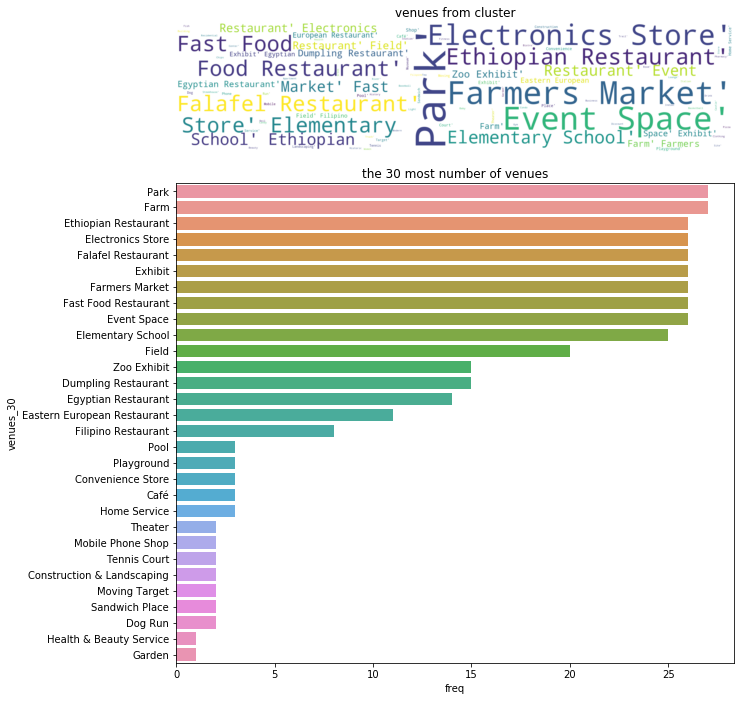

In [65]:
plotting_cluster(cluster_4)